In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyrotd
import os
import re
import glob
import sys
import subprocess
from scipy import signal
from read_params import read_params
from filter_BU import filt_B
from my_pyrotd import *

%matplotlib inline
rcparams = {'font.size': 16,
            'xtick.labelsize': 10,
            'ytick.labelsize': 10,
            'legend.fontsize': 14,
            'axes.titlesize': 16,
            'axes.labelsize': 14,
            'lines.linewidth': 2,
            'figure.dpi': 600}
plt.rcParams.update(rcparams)

plt.tight_layout()
if "py_modules" not in sys.path:
    sys.path.append("/ccs/home/hzfmer/file_back/scripts/py_modules")

<Figure size 3600x2400 with 0 Axes>

## read_params
Extract useful parameters that can be used in multiple scripts


In [2]:
args = read_params()

nsrc = args['NSRC']
tmax = args['TMAX']
dt = args['DT']
nt_mom = args['NST']
nsrc = args['NSRC']
read_step = args['READ_STEP']
ntskp, wstep = args['NTISKP'], args['WRITE_STEP']
skip = wstep * ntskp
nt = np.int(tmax / dt)
t = np.linspace(0, nt * dt, nt // ntskp)
NX, NY, NZ = args['X'], args['Y'], args['Z']
base_x = args['SXRGO'].strip('\'')
base_y = args['SYRGO'].strip('\'')
base_z = args['SZRGO'].strip('\'')


# sliprate computed from srf.file
ft_dim = {'6.35': (354, 212), '7.35': (980, 240), '8.45': (5116, 220)}
M = re.findall(r"\d+\.\d+", os.getcwd().split('/')[-1])[0]
nx, nz = ft_dim[M]
print("Size of the fault: ", nx, nz)
slipr = np.fromfile('sliprate.bin', 'f').reshape((-1, nz, nx))
nt_slip = slipr.shape[0]

# gp-fitted source
gp_src = np.fromfile('gp_src.bin', dtype='f').reshape((nz, nx, 15))
gp_slip = gp_src[:, :, 4]
gp_init = gp_src[:, :, 5]
gp_rtime = gp_src[:, :, 6]

Size of the fault:  5116 220


In [3]:
f = 0.5
line = {0.2: 61, 0.5: 52, 1: 46}
sa = np.fromfile(f'gmrotD50_{f:05.2f}Hz.bin',
                 dtype='float32').reshape((4200, 6320))
sa_cb = np.fromfile(f'/gpfs/alpine/geo112/scratch/hzfmer/LA/gp_rupture_test/LA/data_for_Zhifeng/sa_cb_site_M{M}_T{int(1 / f)}.bin', dtype='float32')
sites = np.genfromtxt(f'stat.txt', dtype='int', skip_header=1)
data_gmpe = np.fromfile(
    f'/gpfs/alpine/geo112/scratch/hzfmer/LA/gp_rupture_test/LA/gp_rupture_test/scripts/sa_GMPE_site_M{M}_T{int(1 / f)}.bin', dtype='f').reshape((-1, 3))
dist, sa_gmpe, sa_sigma_gmpe = (data_gmpe[:, i] for i in range(3))
high = 10 ** (np.log10(sa_gmpe) + np.abs(np.log10(sa_sigma_gmpe)))
stname = [line.rstrip('\n') for line in open('site_names.txt')]
seis = np.load(
    f'/gpfs/alpine/geo112/scratch/hzfmer/LA/gp_rupture_test/LA/data_for_Zhifeng/seis{M.split(".")[0]}.npy', allow_pickle=True)[()]

In [4]:
dt, nt = 0.05, 8000
dt2, nt2 = 0.025, 12000

i = np.random.randint(len(sites))
sa_awp, sa_pyrotd, sa_ssmgrm, sa_rotd50 = np.zeros((len(sites), )), np.zeros((len(sites), )), np.zeros((len(sites), )), np.zeros((len(sites), ))
sa_pyrotd_filt = np.zeros((len(sites), ))
try:
    sa_ssmgrm = np.fromfile(f'sa_pyrotd_cb_T{int(1 / f)}.bin', dtype='float32')
    sa_pyrotd = np.fromfile(f'sa_pyrotd_awp_T{int(1 / f)}.bin', dtype='float32')
    for i in range(len(sites)):
        ix, iy, _ = sites[i]
        sa_awp[i] = sa[iy - 1, ix - 1] / 9.8 
    raise FileNotFoundError
    
except FileNotFoundError:
    # for i in range(len(sites)):
    for i in np.random.randint(len(sites), size=1):
        print(f"Computing sa at site {i} / {len(sites)}", end="\r")
        ix, iy, _ = sites[i]
        sa_awp[i] = sa[iy - 1, ix - 1] / 9.8 

    #     velx = np.loadtxt(f'output_sfc/SX_0_{ix:04d}_{iy:04d}_0001.dat')
    #     vely = np.loadtxt(f'output_sfc/SY_0_{ix:04d}_{iy:04d}_0001.dat')
    #     # velx = filt_B(velx, 1 / dt, 0.01, 2)
    #     # vely = filt_B(vely, 1 / dt, 0.01, 2)
    #     accx, accy = (np.diff(x, prepend=0) / dt for x in (velx, vely))                 
    #     sa_pyrotd_filt[i] = my_calc_rotated_spec_accels(dt, accx, accy, [f], 0.05, percentiles=[50], angles=np.arange(180))[0][2] / 9.8   

        velx = np.loadtxt(f'output_sfc/SX_0_{ix:04d}_{iy:04d}_0001.dat')
        vely = np.loadtxt(f'output_sfc/SY_0_{ix:04d}_{iy:04d}_0001.dat')
        velx = filt_B(velx, 1 / dt, 0, 1, causal=False)
        vely = filt_B(vely, 1 / dt, 0, 1, causal=False)
        accx, accy = (np.diff(x, prepend=0) / dt for x in (velx, vely))                 
        sa_pyrotd[i] = my_calc_rotated_spec_accels(dt, accx, accy, [f], 0.05, percentiles=[50], angles=np.arange(180))[0][2] / 9.8   

        # np.savetxt("accx.txt", accx, fmt="%.8f", newline="\n", header=f"{nt} {dt}", comments='')
        # np.savetxt("accy.txt", accy, fmt="%.8f", newline="\n", header=f"{nt} {dt}", comments='') 
        # os.system("./rotd50")
        # sa_rotd[i] = float(subprocess.run("sed -n '{line[f]}p' rotd50_res.txt | awk -F' ' '{{print$4}}'", shell=True,
        #                      stdout=subprocess.PIPE).stdout.decode('UTF-8')) / 9.8 

        velx_cb, vely_cb = seis[stname[i]][1, :], seis[stname[i]][0, :] #CB x-y rotated 90
        velx_cb = filt_B(velx_cb, 1 / dt, 0, 1, causal=False)
        vely_cb = filt_B(vely_cb, 1 / dt, 0, 1, causal=False)
        accy, accx = (np.diff(x, prepend=0) / dt / 100 for x in (velx_cb, vely_cb))  
        sa_ssmgrm[i] = my_calc_rotated_spec_accels(dt, accx, accy, [f], 0.05, percentiles=[50], angles=np.arange(180))[0][2] / 9.8 
    #     np.savetxt("accx.txt", accx, fmt="%.8f", newline="\n", header=f"{nt} {dt}", comments='')
    #     np.savetxt("accy.txt", accy, fmt="%.8f", newline="\n", header=f"{nt} {dt}", comments='')

    #     os.system("./rotd50")
    #     sa_rotd50[i] = float(subprocess.run(f"sed -n '{line[f]}p' rotd50_res.txt | awk -F' ' '{{print$4}}'", shell=True,  # line46: 1s
    #                          stdout=subprocess.PIPE).stdout.decode('UTF-8')) / 9.8
    print(stname[i], sa_awp[i], sa_cb[i], sa_pyrotd[i], sa_ssmgrm[i])

    sa_ssmgrm.astype('float32').tofile(f'sa_pyrotd_cb_T{int(1 / f)}.bin')
    sa_pyrotd.astype('float32').tofile(f'sa_pyrotd_awp_T{int(1 / f)}.bin')

/ccs/home/hzfmer/file_back/programs/rhea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  


1.2424387


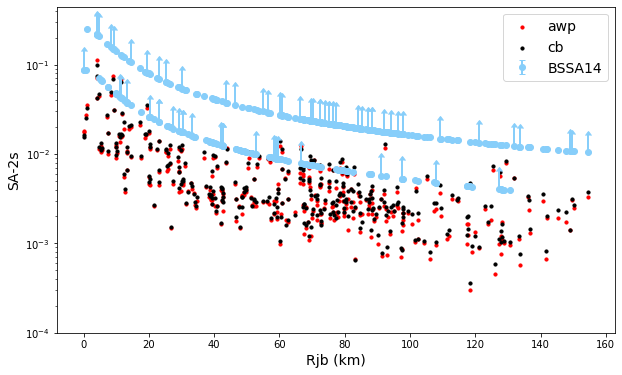

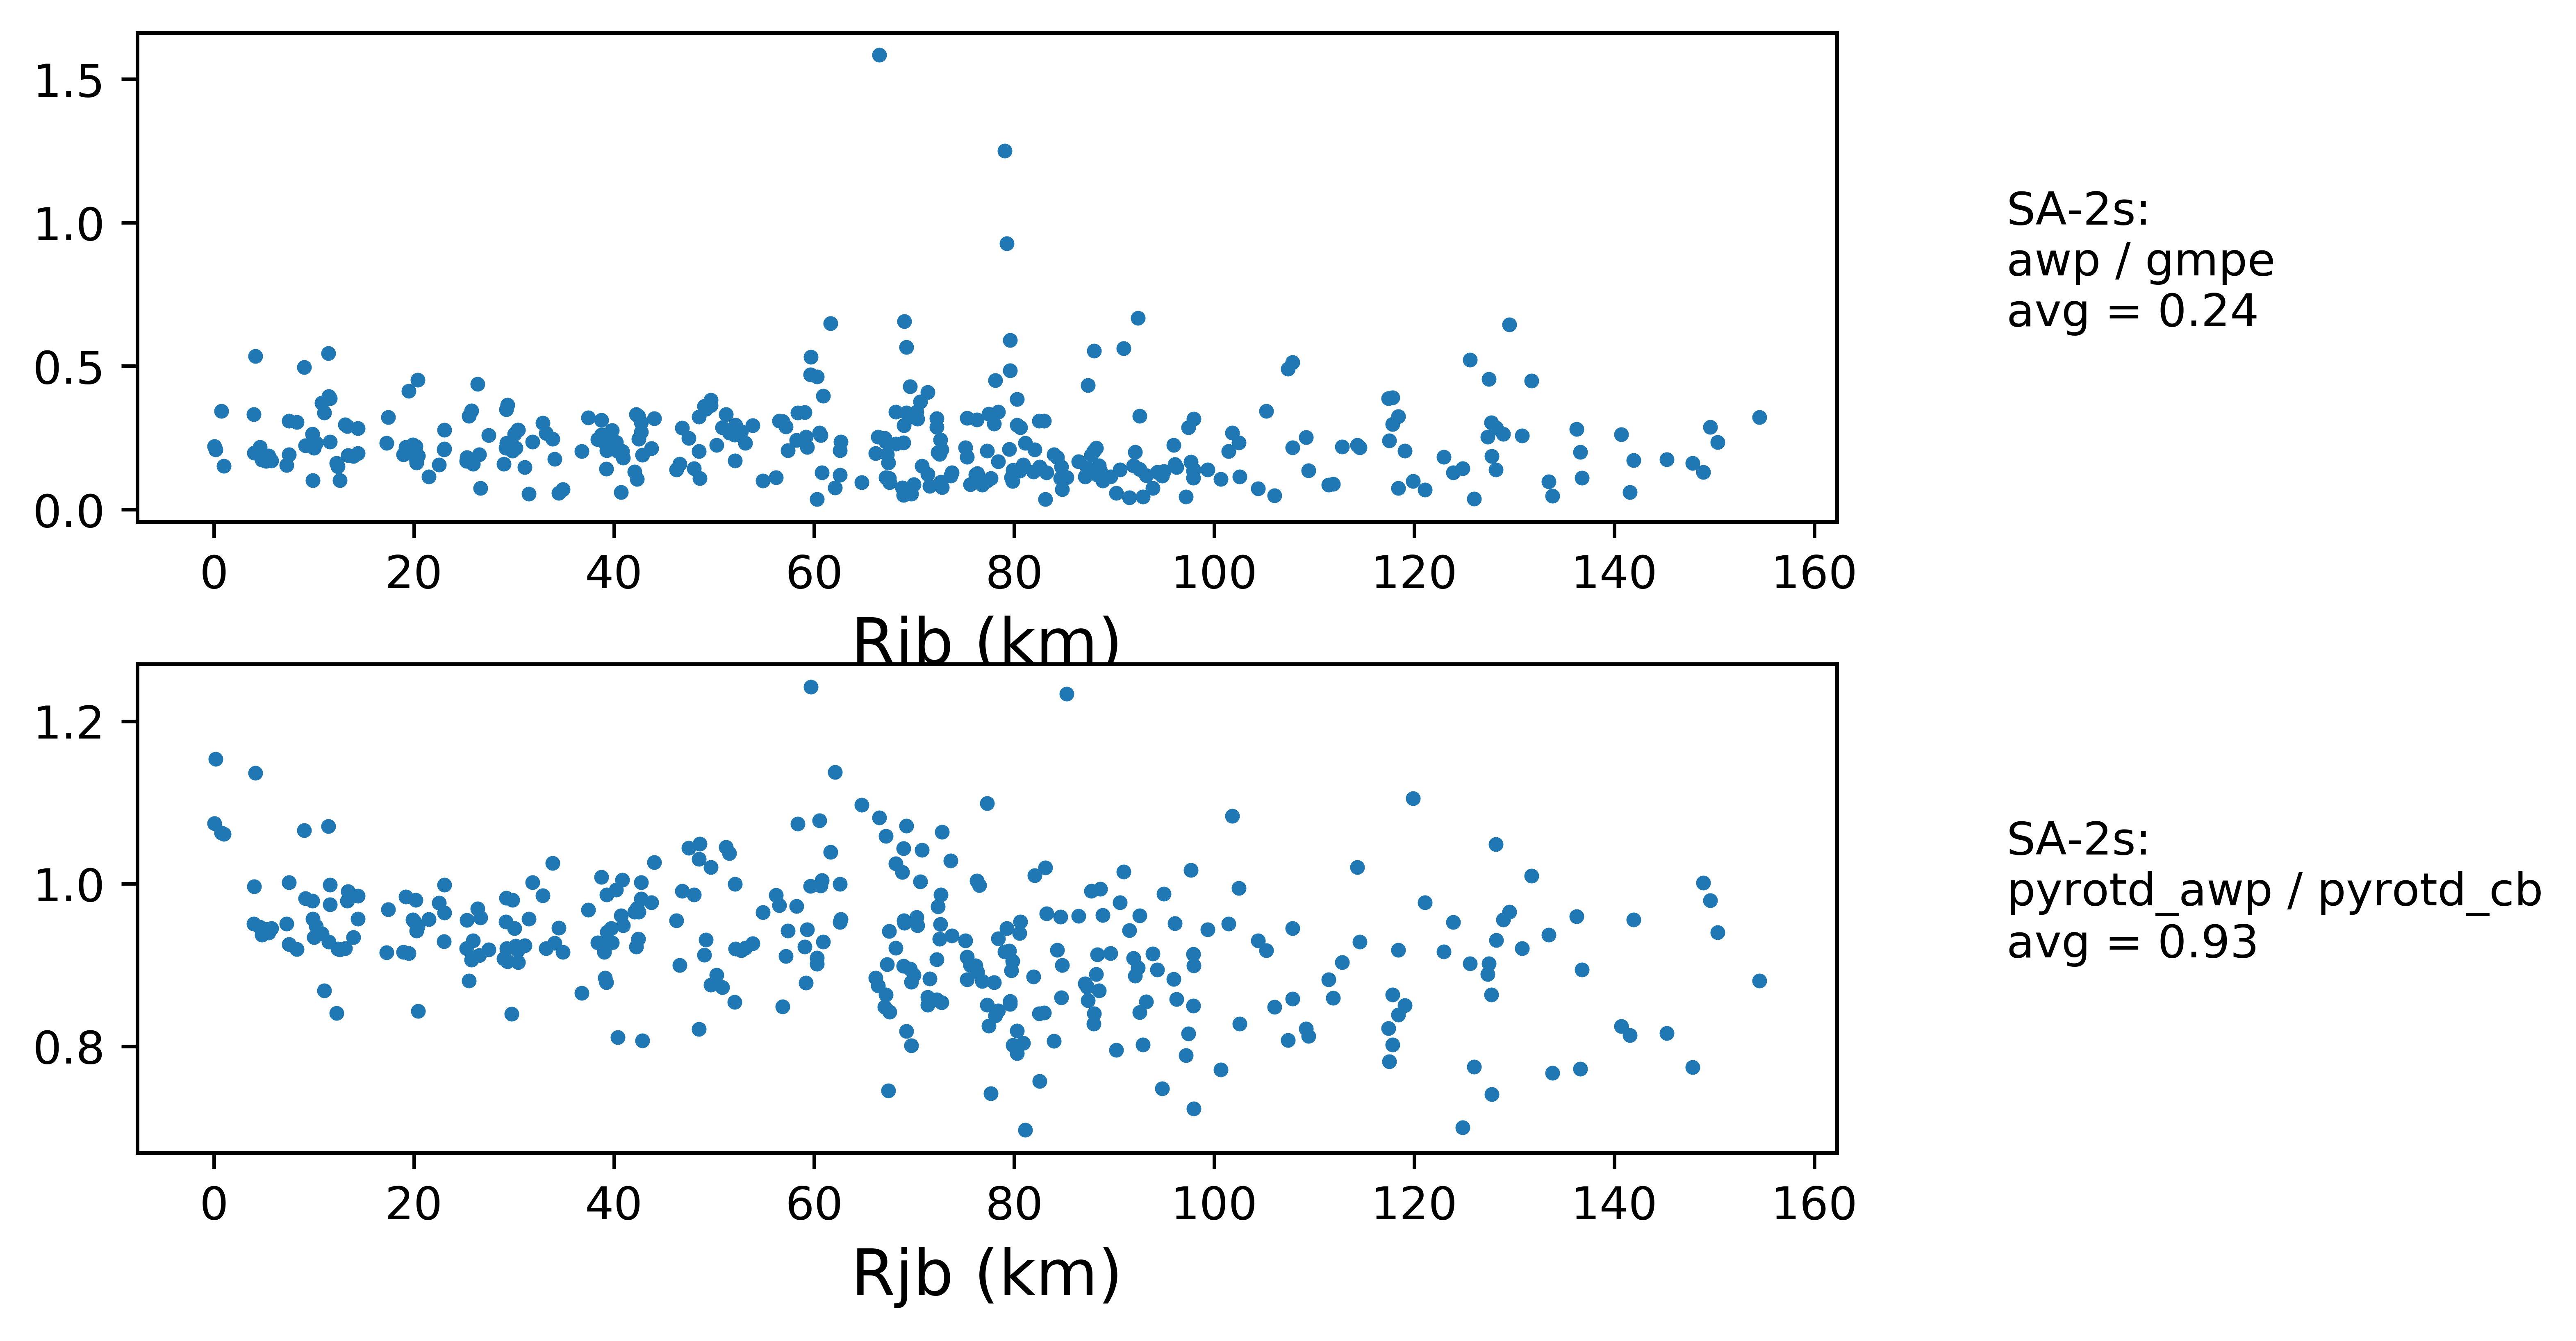

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(dist, sa_pyrotd, s=10, c='r', label='awp')
#ax.scatter(dist, sa_cb, s=10, label='cb_15_12')
#ax.scatter(dist, sa_pyrotd, s=10, label='pyrotd_awp')
#ax.scatter(dist, sa_gmpe, s=10, c='c', label='gmpe')
ax.errorbar(dist, sa_gmpe, yerr=high - sa_gmpe, marker='o', elinewidth=2,
            lolims=True, color='lightskyblue', ls='None', lw=2, errorevery=5,
            label='BSSA14')
ax.scatter(dist, sa_ssmgrm, s=10, c='k', label='cb')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('Rjb (km)')
ax.set_ylabel(f'SA-{int(1 / f)}s')
ax.set_ylim([1e-4, np.log10(1.1 * max(sa_awp))])

fig, ax = plt.subplots(2, 1, dpi=800)
plt.tight_layout(rect=[0, 0, 1, 1])
# ax[0].scatter(dist, np.divide(sa_awp, sa_cb), s=5)
# ax[0].text(
#     1.1, 0.4, f"SA-{int(1/f)}s: \nawp / cb \navg = {np.mean(np.divide(sa_awp, sa_cb)):.2f}", transform=ax[0].transAxes)
# ax[0].set_xlabel('Rjb (km)')
ax[0].scatter(dist, np.divide(sa_awp, sa_gmpe), s=5)
ax[0].text(
    1.1, 0.4, f"SA-{int(1/f)}s: \nawp / gmpe \navg = {np.mean(np.divide(sa_awp, sa_gmpe)):.2f}", transform=ax[0].transAxes)
ax[0].set_xlabel('Rjb (km)')
ax[1].scatter(dist, np.divide(sa_pyrotd, sa_ssmgrm), s=5)
ax[1].text(
    1.1, 0.4, f"SA-{int(1/f)}s: \npyrotd_awp / pyrotd_cb\navg = {np.mean(np.divide(sa_pyrotd, sa_ssmgrm)):.2f}", transform=ax[1].transAxes)

# ax[2].scatter(dist, np.divide(sa_pyrotd, sa_pyrotd_filt), s=5)
# ax[2].text(1.1, 0.4, f"nofilter_awp / filter_awp \navg = {np.mean(np.divide(sa_pyrotd, sa_pyrotd_filt)):.2f}", transform=ax[2].transAxes)

ax[-1].set_xlabel('Rjb (km)')
print(max(np.divide(sa_pyrotd, sa_ssmgrm)))

(401, 2)


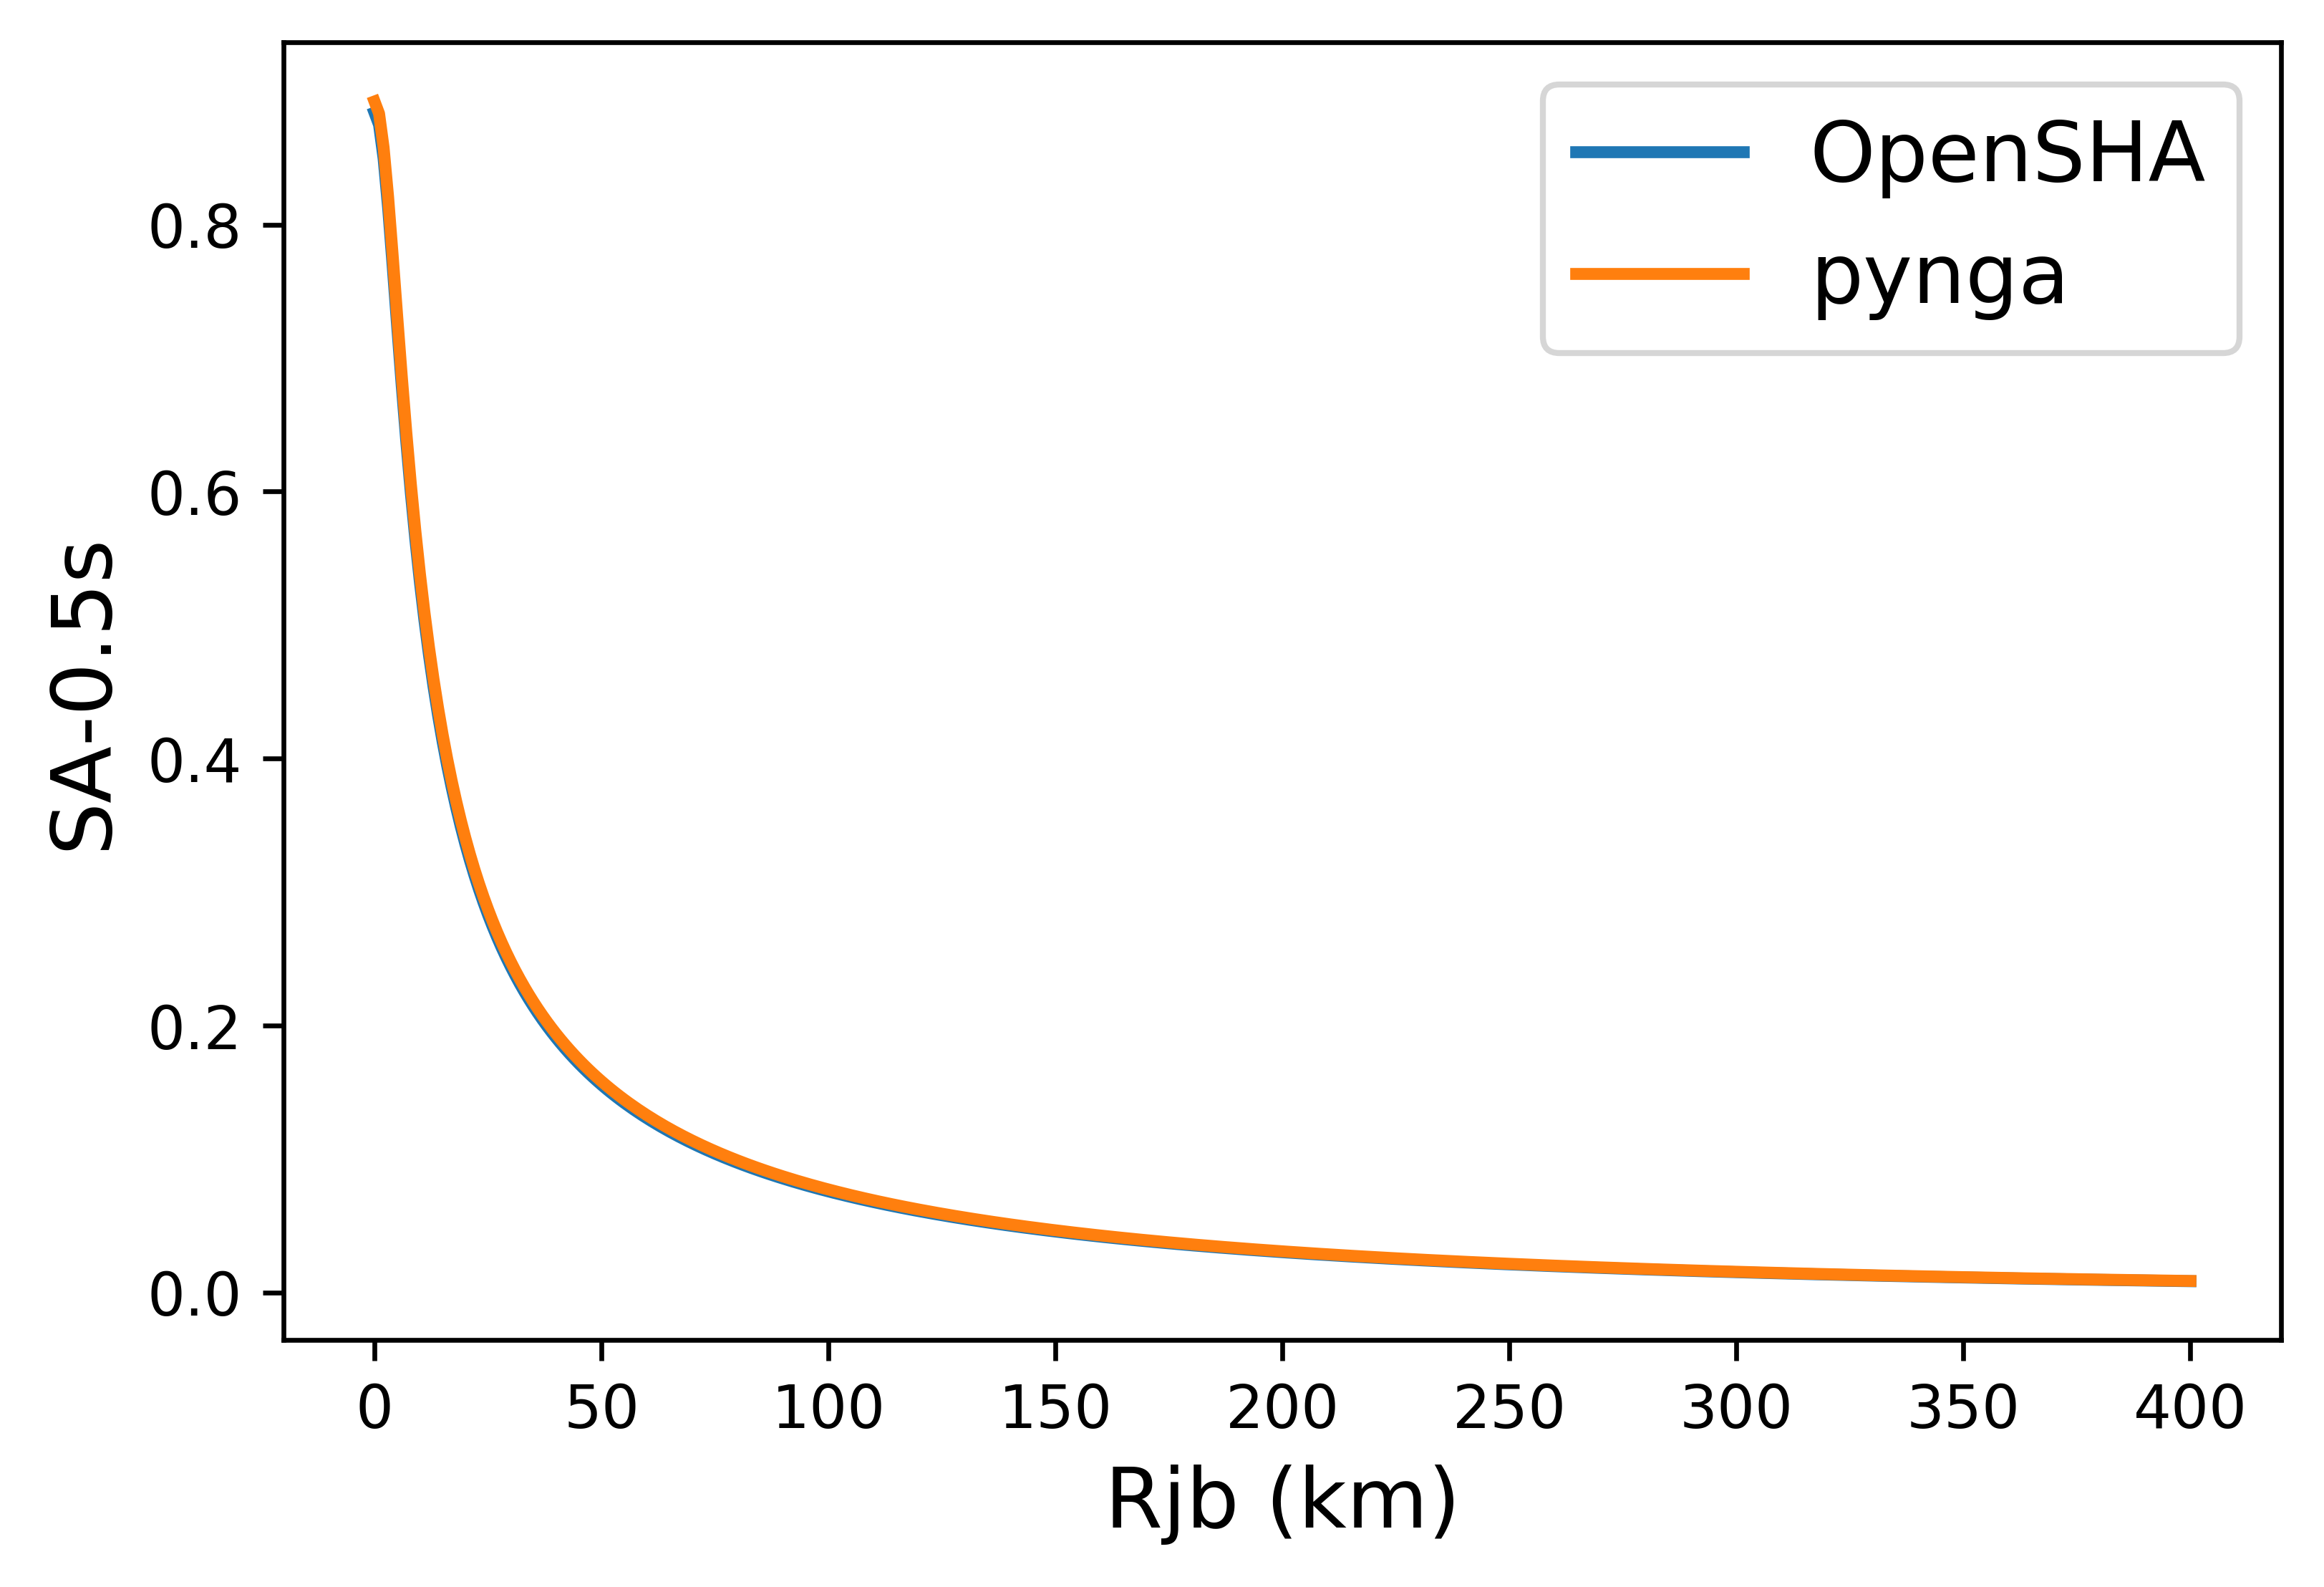

In [3]:
sys.path.append("/ccs/home/hzfmer/scratch/LA/gp_rupture_test/LA/gp_rupture_test/scripts")
import BSSA_2014_nga

bssa14 = np.genfromtxt('bssa14.txt')
print(bssa14.shape)
pynga = np.zeros((401, ))
#  M, T, Rjb (km), 1 (fault_type = strike slip), 1 (region = CA), z1 (km), vs30(m/s)
for rjb in range(401):
    pynga[rjb] = BSSA_2014_nga.BSSA_2014_nga(6.35, 0.5, rjb, 1, 1, 10, 250)[0]

plt.plot(bssa14[:, 0], bssa14[:, 1])
plt.plot(bssa14[:, 0], pynga)
plt.xlabel('Rjb (km)')
plt.ylabel('SA-0.5s')
plt.legend(['OpenSHA', 'pynga'])

(8000,)


(0.5, 2)

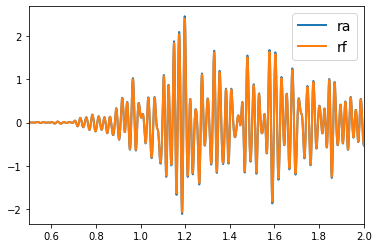

In [60]:
# verify SAs from Daniel's time domain consistent with Freq domain
def shock_response(accels, dt, osc_freq, osc_damping):
    osc_ang_freq = osc_freq * 2 * np.pi
    d_ang_freq = osc_ang_freq * np.sqrt(1 - osc_damping ** 2)
    ra = np.zeros(len(accels), )
    for i in range(2, len(accels)):
        ra[i] = 2 * np.exp(-osc_damping * osc_ang_freq * dt) * np.cos(d_ang_freq * dt) * ra[i - 1]  \
                - np.exp(-2 * osc_damping * osc_ang_freq * dt) * ra[i - 2]  \
                + 2 * osc_damping * osc_ang_freq * dt * accels[i]  \
                + osc_ang_freq * dt * np.exp(osc_damping * osc_ang_freq * dt)  \
                * ( osc_ang_freq / d_ang_freq * (1 - 2 * osc_damping ** 2) * np.sin(d_ang_freq * dt)  \
                  - 2 * osc_damping * np.cos(d_ang_freq * dt) ) * accels[i - 1]
    return ra


dt = 0.05
ra = shock_response(accx, dt, 1, 0.05)
rf = my_calc_spec_accels(dt, accx, [1])
print(rf.shape)
plt.plot(np.linspace(0, 1. / (2 * dt), num=len(ra)), ra, label='ra')
plt.plot(np.linspace(0, 1. / (2 * dt), num=len(ra)), rf, label='rf')
plt.legend()
plt.xlim([0.5, 2])

In [4]:
# Modified pyrotd package
# correct one term; faster
def my_calc_oscillator_resp(freq,
                         fourier_amp,
                         osc_damping,
                         osc_freq,
                         max_freq_ratio=5.,
                         peak_resp_only=False,
                         osc_type='psa'):
    """Compute the time series response of an oscillator.

    Parameters
    ----------
    freq : array_like
        frequency of the Fourier acceleration spectrum [Hz]
    fourier_amp : array_like
        Fourier acceleration spectrum [g-sec]
    osc_damping : float
        damping of the oscillator [decimal]
    osc_freq : float
        frequency of the oscillator [Hz]
    max_freq_ratio : float, default=5
        minimum required ratio between the oscillator frequency and
        then maximum frequency of the time series. It is recommended that this
        value be 5.
    peak_resp_only : bool, default=False
        If only the peak response is returned.
    osc_type : str, default='psa'
        type of response. Options are:
            'sd': spectral displacement
            'sv': spectral velocity
            'sa': spectral acceleration
            'psv': psuedo-spectral velocity
            'psa': psuedo-spectral acceleration
    Returns
    -------
    response : :class:`numpy.ndarray` or float
        time series response of the oscillator
    """
    ang_freq = 2 * np.pi * freq
    osc_ang_freq = 2 * np.pi * osc_freq

    # Single-degree of freedom transfer function
    h = (1 / (ang_freq ** 2. - osc_ang_freq ** 2 - 2.j * osc_damping *
              osc_ang_freq * ang_freq))
    if osc_type == 'sd':
        pass
    elif osc_type == 'sv':
        h *= 1.j * ang_freq
    elif osc_type == 'sa':
        h *= 1 + (1.j * ang_freq) ** 2
    elif osc_type == 'psa':
        #h *= -osc_ang_freq ** 2
        h *= -osc_ang_freq ** 2 - 2.j * osc_damping * osc_ang_freq * ang_freq
    elif osc_type == 'psv':
        h *= -osc_ang_freq
    else:
        raise RuntimeError

    # Adjust the maximum frequency considered. The maximum frequency is 5
    # times the oscillator frequency. This provides that at the oscillator
    # frequency there are at least tenth samples per wavelength.
    n = len(fourier_amp)
    m = max(n, int(max_freq_ratio * osc_freq / freq[1]))
    scale = float(m) / float(n)
  
    # Scale factor is applied to correct the amplitude of the motion for the
    # change in number of points
    resp = scale * np.fft.irfft(fourier_amp * h, 2 * (m - 1))

    if peak_resp_only:
        resp = np.abs(resp).max()

    return resp

def my_calc_rotated_percentiles(accels, angles, percentiles=None):
    """Compute the response spectrum for a time series.

    Parameters
    ----------
    accels : list of array_like
        pair of acceleration time series
    angles : array_like
        angles to which to compute the rotated time series
    percentiles : array_like or None
        percentiles to return

    Returns
    -------
    rotated_resp : :class:`np.recarray`
        Percentiles of the rotated response. Records have keys:
        'percentile', 'spec_accel', and 'angle'.
    """
    accels = np.asarray(accels)
    percentiles = np.array([0, 50, 100]) \
        if percentiles is None else np.asarray(percentiles)
    angles = np.arange(0, 180, step=1) \
        if angles is None else np.asarray(angles)

    # Compute rotated time series
    radians = np.radians(angles)
    coeffs = np.c_[np.cos(radians), np.sin(radians)]
    
    # From pyrotd, seems to have only concerned the x'-axis maximum
    rotated_time_series = np.dot(coeffs, accels)
    peak_responses = np.abs(rotated_time_series).max(axis=1)
    
    # From Daniel Roten, multiply x' and y', then take sqrt
    coeffs2 = np.c_[-np.sin(radians), np.cos(radians)]
    xr = np.max(np.abs(np.dot(coeffs, accels)), axis=1)
    yr = np.max(np.abs(np.dot(coeffs2, accels)), axis=1)
    peak_responses = np.sqrt(np.multiply(xr, yr))
    
    # Sort this array based on the response
    rotated = np.rec.fromarrays(
        [angles, peak_responses], names='angle,peak_resp')
    rotated.sort(order='peak_resp')
    # Get the peak response at the requested percentiles
    p_peak_resps = np.percentile(
        rotated.peak_resp, percentiles, interpolation='linear')
    # Can only return the orientations for the minimum and maximum value as the
    # orientation is not unique (i.e., two values correspond to the 50%
    # percentile).
    p_angles = np.select(
        [np.isclose(percentiles, 0), np.isclose(percentiles, 100),
         True], [rotated.angle[0], rotated.angle[-1], np.nan])
    return np.rec.fromarrays(
        [percentiles, p_peak_resps, p_angles],
        names='percentile,spec_accel,angle')

def my_calc_rotated_oscillator_resp(angles,
                                 percentiles,
                                 freqs,
                                 fourier_amps,
                                 osc_damping,
                                 osc_freq,
                                 max_freq_ratio=5.):
    """Compute the percentiles of response of a rotated oscillator.

    Parameters
    ----------
    percentiles : array_like
        percentiles to return.
    angles : array_like
        angles to which to compute the rotated time series.
    freq : array_like
        frequency of the Fourier acceleration spectrum [Hz]
    fourier_amps : [array_like, array_like]
        pair of Fourier acceleration spectrum [g-sec]
    osc_damping : float
        damping of the oscillator [decimal]
    osc_freq : float
        frequency of the oscillator [Hz]
    max_freq_ratio : float, default=5
        minimum required ratio between the oscillator frequency and
        then maximum frequency of the time series. It is recommended that this
        value be 5.
    peak_resp_only : bool, default=False
        If only the peak response is returned.

    Returns
    -------
    response : :class:`numpy.ndarray` or float
        time series response of the oscillator
    """

    # Compute the oscillator responses
    osc_ts = np.vstack([
        my_calc_oscillator_resp(
            freqs,
            fa,
            osc_damping,
            osc_freq,
            max_freq_ratio=max_freq_ratio,
            peak_resp_only=False) for fa in fourier_amps
    ])
    # Compute the rotated values of the oscillator response
    rotated_percentiles = my_calc_rotated_percentiles(osc_ts, angles, percentiles)

    # Stack all of the results
    return [(osc_freq, ) + rp.tolist() for rp in rotated_percentiles]



def my_calc_spec_accels(time_step,
                     accel_ts,
                     osc_freqs,
                     osc_damping=0.05,
                     max_freq_ratio=5):
    """Compute the psuedo-spectral accelerations.

    Parameters
    ----------
    time_step : float
        time step of the time series [s]
    accel_ts : array_like
        acceleration time series [g]
    osc_freqs : array_like
        natural frequency of the oscillators [Hz]
    osc_damping : float
        damping of the oscillator [decimal]. Default of 0.05 (i.e., 5%)
    max_freq_ratio : float, default=5
        minimum required ratio between the oscillator frequency and
        then maximum frequency of the time series. It is recommended that this
        value be 5.

    Returns
    -------
    resp_spec : :class:`np.recarray`
        computed pseudo-spectral acceleration [g]. Records have keys:
        'osc_freq', and 'spec_accel'
    """
    fourier_amp = np.fft.rfft(accel_ts)
    freq = np.linspace(0, 1. / (2 * time_step), num=fourier_amp.size)

#     spec_accels = [
#         my_calc_oscillator_resp(
#             freq,
#             fourier_amp,
#             osc_damping,
#             of,
#             max_freq_ratio=max_freq_ratio,
#             peak_resp_only=True) for of in osc_freqs
#     ]
#     return np.rec.fromarrays(
#         [osc_freqs, spec_accels], names='osc_freq,spec_accel')
    
    spec_accels = [
        my_calc_oscillator_resp(
            freq,
            fourier_amp,
            osc_damping,
            of,
            max_freq_ratio=max_freq_ratio,
            peak_resp_only=True,
            osc_type='sd') for of in osc_freqs
    ]
    return np.rec.fromarrays(
        [osc_freqs, spec_accels], names='osc_freq,spec_accel')
##     To compare with shock_response, uncomment below
#     spec_accels = [
#         my_calc_oscillator_resp(
#             freq,
#             fourier_amp,
#             osc_damping,
#             of,
#             max_freq_ratio=max_freq_ratio,
#             peak_resp_only=False) for of in osc_freqs
#     ]
#     return spec_accels[0]

def my_calc_rotated_spec_accels(time_step,
                             accel_a,
                             accel_b,
                             osc_freqs,
                             osc_damping=0.05,
                             percentiles=None,
                             angles=None,
                             max_freq_ratio=5):
    """Compute the rotated psuedo-spectral accelerations.

    Parameters
    ----------
    time_step : float
        time step of the time series [s]
    accel_a : array_like
        acceleration time series of the first motion [g]
    accel_b : array_like
        acceleration time series of the second motion that is perpendicular to
        the first motion [g]
    osc_freqs : array_like
        natural frequency of the oscillators [Hz]
    osc_damping : float
        damping of the oscillator [decimal]. Default of 0.05 (i.e., 5%)
    percentiles : array_like or None
        percentiles to return. Default of [0, 50, 100],
    angles : array_like or None
        angles to which to compute the rotated time series. Default of
        np.arange(0, 180, step=1) (i.e., 0, 1, 2, .., 179).
    max_freq_ratio : float, default=5
        minimum required ratio between the oscillator frequency and
        then maximum frequency of the time series. It is recommended that this
        value be 5.
    Returns
    -------
    rotated_resp : :class:`np.recarray`
        computed pseudo-spectral acceleration [g] at each of the percentiles.
        Records have keys: 'osc_freq', 'percentile', 'spec_accel', and 'angle'
    """
    percentiles = [0, 50, 100] \
        if percentiles is None else np.asarray(percentiles)
    angles = np.arange(0, 180, step=1) \
        if angles is None else np.asarray(angles)

    assert len(accel_a) == len(accel_b), 'Time series not equal lengths!'
    
    # Compute the Fourier amplitude spectra
    fourier_amps = [np.fft.rfft(accel_a), np.fft.rfft(accel_b)]
    freqs = np.linspace(0, 1. / (2 * time_step), num=fourier_amps[0].size)
    
    groups = [
        my_calc_rotated_oscillator_resp(
            angles,
            percentiles,
            freqs,
            fourier_amps,
            osc_damping,
            of,
            max_freq_ratio=max_freq_ratio) for of in osc_freqs
    ]
    records = [g for group in groups for g in group]

    # Reorganize the arrays grouping by the percentile
    rotated_resp = np.rec.fromrecords(
        records, names='osc_freq,percentile,spec_accel,angle')
    return rotated_resp

## Synthetics analysis

In [12]:
import pandas
psa = pandas.read_csv('/gpfs/alpine/geo112/scratch/hzfmer/LA/gp_rupture_test/LA/data_for_Zhifeng/study_15_4_psa.csv')
src_id = {'6.35':76, '7.35':128, '8.45':68}

In [49]:
psa.head(5)
pd = psa[(psa['Source_ID'] == src_id[M]) & (psa['IM_Type_Component'] == 'RotD50') & (psa['IM_Type_Value'] == 1/f)]
pd[pd['CS_Short_Name'] == f'{stname[i]}']['IM_Value'] / 980

KeyError: 1

s668 0.04289387440194889 0.043203145 0.042188447 0.042341817 0.2176908 3268    0.043019
Name: IM_Value, dtype: float64
Site s668(3958, 2105): Rjb = 4.026796817779541 km


Text(0.5, 0, 'Time (s)')

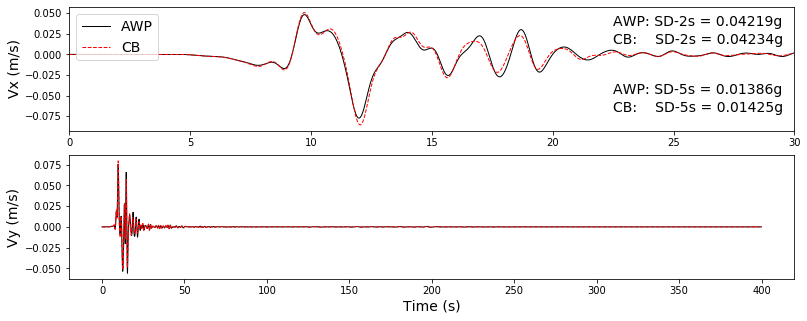

In [50]:
[b, a] = signal.butter(4, 0.2)
idx = np.argwhere(dist < 10)
i = np.random.choice(idx[:, 0], 1)[0]
sa = pd[pd['CS_Short_Name'] == f'{stname[i]}']['IM_Value'] / 980
print(stname[i], sa_awp[i], sa_cb[i], sa_pyrotd[i], sa_ssmgrm[i], sa_gmpe[i], sa)
#i = 200
dt = 0.05
def rotate_v(vx, vy, theta):
    theta = np.radians(theta)
    vx_out = vx * np.cos(theta) - vy * np.sin(theta)
    vy_out = vx * np.sin(theta) + vy * np.cos(theta)
    return vx_out, vy_out

ix, iy, _ = sites[i]
print(f"Site {stname[i]}({ix}, {iy}): Rjb = {dist[i]} km")
# velx0 = np.loadtxt(f'output_sfc_back/SX_0_{ix:04d}_{iy:04d}_0001.dat')
# vely0 = np.loadtxt(f'output_sfc_back/SY_0_{ix:04d}_{iy:04d}_0001.dat')
# velx0 = filt_B(velx0, 1 / dt, 0.01, 1)
# vely0 = filt_B(vely0, 1 / dt, 0.01, 1)
# velx0, vely0 = rotate_v(velx0, vely0, -35)
# accx0, accy0 = (np.diff(x, prepend=0) / dt for x in (velx0, vely0))
# sa2_0 = my_calc_rotated_spec_accels(dt, accx0, accy0, [0.5], 0.05, percentiles=[50], angles=np.arange(180))[0][2] / 9.8   
# sa5_0 = my_calc_rotated_spec_accels(dt, accx0, accy0, [0.2], 0.05, percentiles=[50], angles=np.arange(180))[0][2] / 9.8   
 
velx1 = np.loadtxt(f'output_sfc/SX_0_{ix:04d}_{iy:04d}_0001.dat')
vely1 = np.loadtxt(f'output_sfc/SY_0_{ix:04d}_{iy:04d}_0001.dat')
# velx1 = signal.lfilter(b, a, velx1[::-1])[::-1]
# vely1 = signal.lfilter(b, a, vely1[::-1])[::-1]
velx1 = filt_B(velx1, 1 / dt, 0, 1, causal=False)
vely1 = filt_B(vely1, 1 / dt, 0, 1, causal=False)
velx1, vely1 = rotate_v(velx1, vely1, -35)
accx1, accy1 = (np.diff(x, prepend=0) / dt for x in (velx1, vely1))
sa2_1 = my_calc_rotated_spec_accels(dt, accx1, accy1, [0.5], 0.05, percentiles=[50], angles=np.arange(180))[0][2] / 9.8   
sa5_1 = my_calc_rotated_spec_accels(dt, accx1, accy1, [0.2], 0.05, percentiles=[50], angles=np.arange(180))[0][2] / 9.8   
 
    
velx2 = seis[stname[i]][1, :] / 100
vely2 = seis[stname[i]][0, :] / 100
velx2 = filt_B(velx2, 1 / dt, 0, 1, causal=False)
vely2 = filt_B(vely2, 1 / dt, 0, 1, causal=False)
accx2, accy2 = (np.diff(x, prepend=0) / dt for x in (velx2, vely2))
sa2_2 = my_calc_rotated_spec_accels(dt, accx2, accy2, [0.5], 0.05, percentiles=[50], angles=np.arange(180))[0][2] / 9.8   
sa5_2 = my_calc_rotated_spec_accels(dt, accx2, accy2, [0.2], 0.05, percentiles=[50], angles=np.arange(180))[0][2] / 9.8   
 
     
fig, ax = plt.subplots(2, 1, figsize=(13, 5))
# ax[0].plot(t, velx0, 'g', lw=1, label='AWP0')
ax[0].plot(t, velx1, 'k', lw=1, label='AWP')
ax[0].plot(t, velx2, 'r--', lw=1, label='CB')
ax[0].set_xlim([0, 30])
ax[0].legend(loc=2)
ax[0].set_ylabel('Vx (m/s)')
# ax[0].text(0.75, 0.85, f"AWP0: SA-2s = {sa2_0:.5f}g", transform=ax[0].transAxes, fontsize=14)
ax[0].text(0.75, 0.85, f"AWP: SD-2s = {sa2_1:.5f}g", transform=ax[0].transAxes, fontsize=14)
ax[0].text(0.75, 0.7, f"CB:    SD-2s = {sa2_2:.5f}g", transform=ax[0].transAxes, fontsize=14)
ax[0].text(0.75, 0.3, f"AWP: SD-5s = {sa5_1:.5f}g", transform=ax[0].transAxes, fontsize=14)
ax[0].text(0.75, 0.15, f"CB:    SD-5s = {sa5_2:.5f}g", transform=ax[0].transAxes, fontsize=14)

# ax[1].plot(t, vely0, 'g', lw=1, label='AWP0')
ax[1].plot(t, vely1, 'k', lw=1)
ax[1].plot(t, vely2, 'r--', lw=1)
ax[1].set_ylabel('Vy (m/s)')
ax[1].set_xlabel('Time (s)')


In [3]:
# plot time series
# Verify extract_ssmgrm works fine
import struct
nt, ny, nx = 200, 4200, 6320
iy, ix = 1416, 2939
dt = 0.05
res0 = []
res = []
# M = 6.35
for i in range(1, 41):
    print(f"\rProcessing step {i}: SX_0_{i * 2000:07d}", end="\r", flush=True)
    sfc_dir = f'/gpfs/alpine/geo112/scratch/hzfmer/LA/gp_rupture_test/LA/gp_rupture_test/gp_021219_Scott_{M}_noplas_GPU_2hz/'
    fid = open(sfc_dir + f'output_sfc/SX_0_{i * 2000:07d}', 'rb')
    for j in range(nt):
        skip = 4 * (j * ny * nx + iy * nx + ix)
        fid.seek(skip, 0)
        tmp = struct.unpack('f', fid.read(4))
        res.append(tmp)
    fid.close()
    
    fid = open(sfc_dir.replace('GPU_', '') + f'output_sfc/SX_0_{i * 2000:07d}', 'rb')
    for j in range(nt):
        skip = 4 * (j * ny * nx + iy * nx + ix)
        fid.seek(skip, 0)
        tmp = struct.unpack('f', fid.read(4))
        res0.append(tmp)
    fid.close()
    
    # data = np.fromfile(f'/gpfs/alpine/geo112/scratch/hzfmer/LA/gp_rupture_test/LA/gp_rupture_test/' +
    #                    f'gp_021219_Scott_{M}_noplas_GPU_2hz/output_sfc/SX_0_{i * 2000:07d}', dtype='f').reshape((nt, ny, nx))
    # res.append(data[:, iy, ix])
res = np.array(res).reshape((len(res), ))
res0 = np.array(res0).reshape((len(res0), ))
res2 = np.loadtxt(sfc_dir + f'output_sfc/SX_0_{ix+1}_{iy+1}_0001.dat')  


(8000,)


Text(0, 0.5, 'V (m/s)')

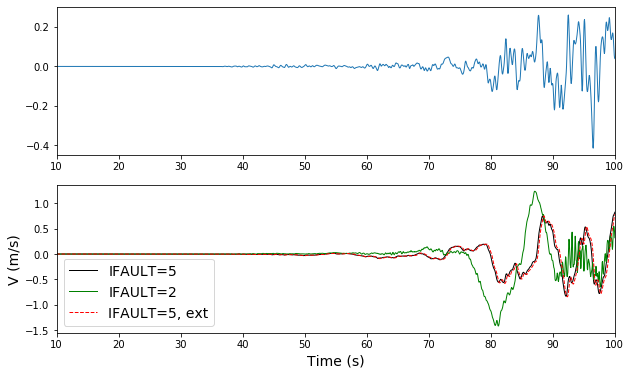

In [4]:
dt = 0.05
dif = res - res2
print(dif.shape)
fig, ax = plt.subplots(2,1, figsize=(10, 6))
ax[0].plot(np.arange(len(res)) * dt, dif, lw=1)
ax[0].set_xlim([10, 100])
ax[1].plot(np.arange(len(res)) * dt, res , 'k', lw=1)
ax[1].plot(np.arange(len(res)) * dt, res0 , 'g', lw=1)
ax[1].plot(np.arange(len(res)) * dt, res2 , 'r--', lw=1)
ax[1].legend(['IFAULT=5', 'IFAULT=2', 'IFAULT=5, ext'])
ax[1].set_xlim([10, 100])
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('V (m/s)')

## Source verification

In [7]:

nt_ref = 4000
dx = 0.2
theta_rot = 35
f = open(glob.glob('./*.srf')[0],'r')
f.readline()
f.readline()
token = f.readline()
dtop = int(float(f.readline().split()[2]) / dx)
print(f.readline())

    
nx = int(token.split()[2])
nz = int(token.split()[3])
npt = nx * nz
sliprate = np.zeros((nz, nx, nt_ref))

for j in range(nz):
    for i in range(nx):
        nl1 = f.readline().split()
        nl2 = f.readline().split() 
        tinit= float(nl1[6])
        if abs(tinit - gp_init[2 * j, 2 * nx - 1 - 2 * i]) > 1e-3:
            print(i, j, tinit, gp_init[2 * j, 2 * nx - 1 - 2 * i])
            sys.exit(-1)
        dt = float(nl1[7])
        t1 = int(np.floor(tinit/dt))
        nt1 = int(nl2[2])
        nskip1 = int(np.ceil(nt1 / 6.))
        sliprate1 = np.zeros((nt1), dtype=float)
        p1 = 0
        for l in range(nskip1):
            tmp = f.readline()
            nt = len(tmp.split())
            for n in range(nt):
                sliprate1[p1] = float(tmp.split()[n]) / 1.e2
                p1 += 1
                
        sliprate[j, i, t1 : t1+len(sliprate1)] = sliprate1.copy()
        if abs(sum(sliprate1) * dt - gp_slip[2 * j, 2 * nx - 1 - 2 * i]) > 1e-3:
            print(i, j, sum(sliprate1) * dt, gp_slip[2 * j, 2 * nx - 1 - 2 * i])
            sys.exit(-1)
            
        if abs(sum(sliprate1) * dt - sum(slipr[:, 2 * j, 2 * nx - 1 - 2 * i]) * dt) > 1e-3:
            print("slipr", i, j, sum(sliprate1) * dt, sum(slipr[:, 2*j, 2*i]) * dt, sum(slipr[:, 2 * j, 2 * nx - 1 - 2 * i]) * dt)
            sys.exit(-1)
        # trise = len(sliprate1) * dt
f.close()      

POINTS 281380

slipr 0 0 0.16057464365000007 0.0 0.0


SystemExit: -1

/ccs/home/hzfmer/file_back/programs/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


1639 74
1853 100
996 94
206 91
1417 89


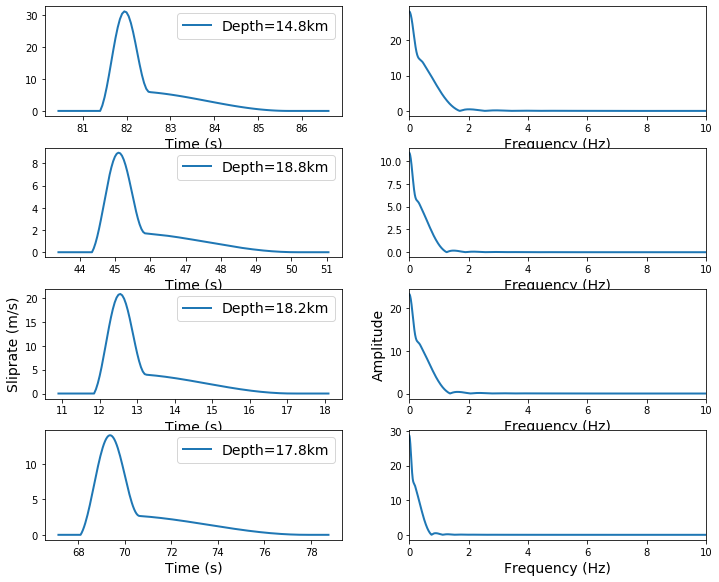

In [4]:
# plot time series and fourier spectra at some random sites
N = 4
dt = 0.05
fig, ax = plt.subplots(N, 2, figsize=(10,8), )
plt.tight_layout(w_pad=3)
freq = np.linspace(0, 1 / dt, np.shape(sliprate)[-1])
for i in range(N):
    while True:
        ix = np.random.randint(nx)
        iz = np.random.randint(nz)
        print(ix, iz)
        try:
            t1 = np.int(np.floor(np.argwhere(sliprate[iz, ix, :]>0)[0]))
            t2 = np.int(np.floor(np.argwhere(sliprate[iz, ix, :]>0)[-1]))
        except IndexError:
            continue
            t1 = 0
        if t1 > 0:
            # tmp = signal.lfilter(b, a, sliprate[iz, ix, :])
            ax[i, 0].plot(np.arange(t1 - 20, t2 + 20) * dt, sliprate[iz, ix, t1 - 20: t2 + 20])
            # ax[i, 0].plot(np.arange(t1 - 20, t2 + 20) * dt, tmp[t1 - 20 : t2 + 20])
            ax[i, 0].legend([f'Depth={iz * dx:.1f}km'])
            ax[i, 0].set_xlabel('Time (s)')
            ax[int(N//2), 0].set_ylabel('Sliprate (m/s)')
            fslip = abs(np.fft.fft(sliprate[iz, ix, :]) * dt)
            ax[i, 1].plot(freq, fslip)
            ax[i, 1].set_xlabel('Frequency (Hz)')
            ax[i, 1].set_xlim([0, 10])
            ax[int(N//2), 1].set_ylabel('Amplitude')
            break
        else:
            continue

        

ix=3865, iz=72
rupture time = 376, rise time = 22, max time = 378 ratio = 0.09090909090909091
Before-peak slip:  12.4989395
Total slip, total slip / 3:  55.352737 18.450912475585938
0.026133984
ix=3562, iz=72
rupture time = 697, rise time = 3, max time = 697 ratio = 0.0
Before-peak slip:  0.0
Total slip, total slip / 3:  0.6364175 0.21213916937510172


ValueError: zero-size array to reduction operation maximum which has no identity

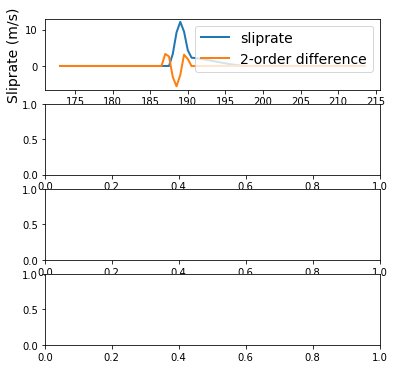

In [7]:
## Look at sliprate on randomly selected subfaults
## To see if there is any pattern in the kinematic source

fig, ax = plt.subplots(4, 1, figsize=(6, 6))

iix = [3865, 3562]
iiz = [72, 72]
for i in range(4):
    np.random.seed()
    ix = np.random.randint(nx)
    iz = np.random.randint(nz)
    if i < 2:
        ix = iix[i]
        iz = iiz[i]
    disp = iz * nx + ix
    print(f'ix={ix}, iz={iz}')
    buf_slip = slipr[:, iz, ix]
    max_slip = max(abs(buf_slip))
    tot_slip = np.sum(buf_slip)
    if tot_slip > 1e-9:
        ruptt = np.argwhere(buf_slip > 1e-9)[0][0]
        riset = np.sum(buf_slip > 1e-9)
        maxt = np.argmax(buf_slip)
        print(f'rupture time = {ruptt}, rise time = {riset}, max time = {maxt}',
              f'ratio = {(maxt - ruptt) / riset}')
        idx = np.arange(np.max((0, ruptt - 30)), np.min((nt_slip, ruptt + riset + 30)))
        #idx = np.arange(len(buf_slip))
        print("Before-peak slip: ", np.sum(buf_slip[idx[0] : maxt]))
        print("Total slip, total slip / 3: ", tot_slip, tot_slip / 3)
        dif2 = np.pad(np.diff(buf_slip[idx], n=2), [0, 2], 'constant')
        print(np.max(dif2[35 : -35]))
        #dif2 = dif2 / np.max(np.abs(dif2)) * max_slip
        
        ax[i].plot(idx * dt * ntskp, buf_slip[idx], linewidth=2)
        ax[i].plot(idx * dt * ntskp, dif2, linewidth=2)
        ax[i].set_xlabel('Tims (s)')
        ax[i].set_ylabel('Sliprate (m/s)')
    ax[0].legend(['sliprate', '2-order difference'], loc=1)


In [12]:
nx

5116

[1.00000014]
[1.00000074]
[1.00000099]
At ix=1688, iz=131, maxslip=0.0


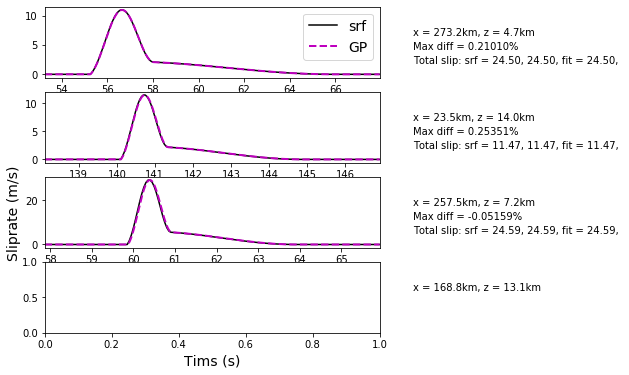

In [13]:
# Implement compare GP source with srf
# Graves-Pitarka kinematic source

def fit_gp2(risetime, t):
    stf = np.zeros((len(t), 1))
    if risetime <= 0:
        return stf
    t = t / risetime
    for i, tt in enumerate(t):
        if tt <=0:
            pass
        elif tt <= 1 / 9:
            stf[i] = 9 * tt
        elif tt <= 1 / 5:
            stf[i] = -9 * tt + 2
        elif tt <= 1:
            stf[i] = (1 - tt) / 4
        stf[i] = stf[i] * 90 / 17 / risetime
    return stf

def fit_liu(tau, t):
    stf = np.zeros((len(t), 1))
    tau1 = 0.13 * tau
    tau2 = tau - tau1
    cn = np.pi / (1.4 * np.pi * tau1 + 1.2 * tau1 + 0.3 * np.pi * tau2)
    for i, tt in enumerate(t):
        if tt < tau1:
            stf[i] = cn * (0.7 - 0.7 * np.cos(np.pi * tt / tau1) + 0.6 * np.sin(0.5 * np.pi * tt / tau1))
        elif tt < 2 * tau1:
            stf[i] = cn * (1.0 - 0.7 * np.cos(np.pi * tt / tau1) + 0.3 * np.cos(np.pi * (tt - tau1) / tau2))
        elif tt < tau:
            stf[i] = cn * (0.3 + 0.3 * np.cos(np.pi * (tt - tau1) / tau2))
        else:
            stf[i] = 0
    return stf

def fit_gp(tau, t):
    stf = np.zeros((len(t), 1))
    tau1 = 0.13 * tau
    tau2 = tau - tau1
    cn = np.pi / (1.5 * np.pi * tau1 + 1.2 * tau1 + 0.2 * np.pi * tau2)
    for i, tt in enumerate(t):
        if tt < 0:
            stf[i] = 0
        elif tt < tau1:
            stf[i] = cn * (0.7 - 0.7 * np.cos(np.pi * tt / tau1) + 0.6 * np.sin(0.5 * np.pi * tt / tau1))
        elif tt < 2 * tau1:
            stf[i] = cn * (1.0 - 0.8 * np.cos(np.pi * tt / tau1) + 0.2 * np.cos(np.pi * (tt - tau1) / tau2))
        elif tt < tau:
            stf[i] = cn * (0.2 + 0.2 * np.cos(np.pi * (tt - tau1) / tau2))
        else:
            stf[i] = 0
    return stf

            
dt = 0.005
[b, a] = signal.butter(4, 0.2, 'low')
[b2, a2] = signal.butter(4, 0.02, 'low')

#slipr2 = np.fromfile('../gp_021219_Scott_8.45_noplas_GPU_2hz/sliprate.bin', 'f').reshape((-1, nz, nx))
fig, ax = plt.subplots(4, 1, figsize=(6, 6))
for i in range(4):
    np.random.seed(i)
    ix = np.random.randint(nx)
    iz = np.random.randint(nz)
    buf_slip = slipr[:, iz, ix]
    #buf_slip2 = slipr2[:, iz, ix]
    ax[i].text(1.1, 0.6, f"x = {ix * 0.1:.1f}km, z = {iz * 0.1:.1f}km",
               transform=ax[i].transAxes)
    if np.max(buf_slip) < 1e-3:
        print(f'At ix={ix}, iz={iz}, maxslip={np.max(buf_slip)}')
        continue
    t_0 = np.arange(0, nt_slip * dt * ntskp, dt * ntskp)
    t_1 = np.arange(0, nt_slip * dt * ntskp, dt)
    fit_slip = fit_gp(gp_rtime[iz, ix], t_1 - gp_init[iz, ix])
    print(sum(fit_slip) * 0.005)
    fit_slip = fit_slip.flatten() * gp_slip[iz, ix] 
    ax[i].plot(t_0, buf_slip, 'k', linewidth=1.5, label="srf")
    #ax[i].plot(t_0, buf_slip2, 'g', linewidth=1.5, label="srf2")
    # ax[i].plot(t_0, sliprate[iz//2, ix//2], 'g', linewidth=1.5, label="sliprate")
    #tmp = signal.lfilter(b, a, buf_slip)
    #tmp2 = signal.lfilter(b2, a2, fit_slip)
    #ax[i].plot(t_0, tmp, 'r--', linewidth=2, label="tmp")
    #ax[i].plot(t_1, tmp2, 'g', linewidth=2, label="tmp2")
    ax[i].plot(t_1, fit_slip, 'm--', linewidth=2, label="GP")
    ax[i].text(1.1, 0.4, f"Max diff = {(max(buf_slip) - max(fit_slip)) / max(buf_slip) * 100:.5f}%",
               transform=ax[i].transAxes)
    ax[i].text(1.1, 0.2, f"Total slip: srf = {sum(buf_slip) * dt * ntskp:.2f}, {gp_slip[iz, ix]:.2f}, fit = {sum(fit_slip) * dt:.2f}, " \
               , transform=ax[i].transAxes)
    #ax[i].set_xlim([gp_init[iz, ix] - 0.1, gp_init[iz, ix] + 0.8])
    ax[i].set_xlim([gp_init[iz, ix] - 2, gp_init[iz, ix] + gp_rtime[iz, ix] + 2])
ax[2].set_ylabel('Sliprate (m/s)') 
ax[3].set_xlabel('Tims (s)')
ax[0].legend(loc=1)

199.995 (40000,)
4.960865052083818e-12


(0, 3.5)

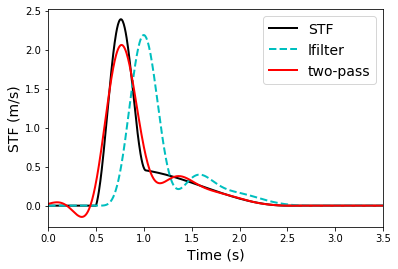

In [7]:
from scipy.signal import butter, lfilter, filtfilt
def fit_gp(tau, t):
    stf = np.zeros((len(t), 1))
    tau1 = 0.13 * tau
    tau2 = tau - tau1
    cn = np.pi / (1.5 * np.pi * tau1 + 1.2 * tau1 + 0.2 * np.pi * tau2)
    for i, tt in enumerate(t):
        if tt < 0:
            stf[i] = 0
        elif tt < tau1:
            stf[i] = cn * (0.7 - 0.7 * np.cos(np.pi * tt / tau1) + 0.6 * np.sin(0.5 * np.pi * tt / tau1))
        elif tt < 2 * tau1:
            stf[i] = cn * (1.0 - 0.8 * np.cos(np.pi * tt / tau1) + 0.2 * np.cos(np.pi * (tt - tau1) / tau2))
        elif tt < tau:
            stf[i] = cn * (0.2 + 0.2 * np.cos(np.pi * (tt - tau1) / tau2))
        else:
            stf[i] = 0
    return stf

t_i, t_d = 0.5, 2
[b, a] = butter(4, 0.02)
t_1 = np.arange(0, 40000 * 0.005, 0.005)
fit_slip = fit_gp(t_d, t_1 - t_i).reshape((len(t_1), ))
print(max(t_1), fit_slip.shape)
s1 = filtfilt(b, a, fit_slip)
s2 = lfilter(b, a, fit_slip)
s3 = signal.lfilter(b, a, s2[::-1])[::-1]

print(max(s1-s3))
plt.plot(t_1, fit_slip, 'k', label='STF')
plt.plot(t_1, s2, 'c--', label='lfilter')
#plt.plot(t_1, s1, 'g-', label='filtfilt')
plt.plot(t_1, s3, 'r-', label='two-pass')
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('STF (m/s)')
plt.xlim([max(0, t_i - 1), t_i + t_d + 1])

116 726
36.9486
0.0


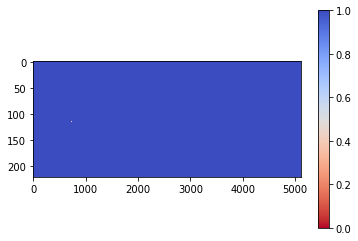

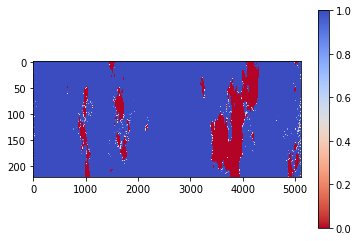

In [50]:
tinit=np.fromfile('tinit.bin', dtype='float32').reshape(nz, nx)
jj, ii = np.unravel_index(tinit.argmin(), tinit.shape)
print(jj, ii)
print(tinit[1, 2])
print(np.min(gp_rtime))
plt.imshow(tinit)
plt.imshow(tinit, aspect=10, cmap='coolwarm_r', vmax=1)
plt.colorbar()

fig, ax = plt.subplots()
h=ax.imshow(np.fliplr(gp_rtime), aspect=10, cmap='coolwarm_r', vmax=1)
plt.colorbar(h, ax=ax)

903073
moment, max_momrate, max_sliprate:  -2105886889738240.0 3675526400000000.0 38.9677
995341
moment, max_momrate, max_sliprate:  -2814267356379873.5 2844223400000000.0 30.3602
226186
moment, max_momrate, max_sliprate:  10799055718318.08 19838882000000.0 0.735781
196162
moment, max_momrate, max_sliprate:  -1763341085850992.8 1381521000000000.0 10.5422


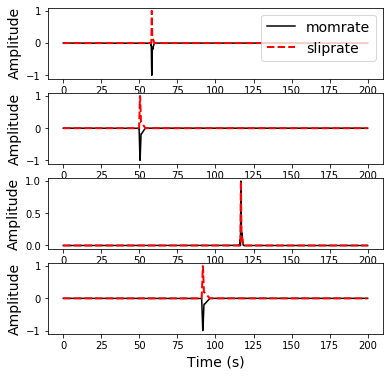

In [14]:
## Compare time histories from momrate.dat and sliprate.bin
## Make sure they are consistent

with open("momrate.dat", 'rb') as f_mom:
    fig, ax = plt.subplots(4, 1, figsize=(6, 6))
    for i in range(4):
        np.random.seed()
        ix = np.random.randint(nx)
        iz = np.random.randint(nz)
        if i == 0:
            ix, iz = 2657, 176
        disp = iz * nx + ix
        print(disp)
        f_mom.seek((12 + 4 * 6 * nt_mom) * disp + 12, 0)
        # momrate has 6 components
        buf_mom = np.frombuffer(f_mom.read(4 * 6 * nt_mom), dtype='f')[::6]
        max_mom = max(abs(buf_mom))
        sum_mom = buf_mom.sum() * dt
        buf_slip = slipr[:, iz, ix]
        max_slip = max(abs(buf_slip))
        if max_slip < 1e-20 or max_mom < 1e-20:
            continue
        buf_mom = buf_mom / max_mom
        buf_slip = buf_slip / max_slip
        print("moment, max_momrate, max_sliprate: ", sum_mom, max_mom, max_slip)
        ax[i].plot(np.arange(0, nt_mom * dt, dt), buf_mom, 'k', linewidth=1.5)
        ax[i].plot(np.arange(0, nt_slip * dt * ntskp, dt * ntskp), buf_slip, 'r--', linewidth=2)
        ax[i].set_ylabel('Amplitude')
    ax[0].legend(['momrate', 'sliprate'], loc=1)
    ax[3].set_xlabel('Time (s)')
    fig.savefig(f'comp_momrate_sliprate_{M}.png', dpi=500, bbox='tight', pad_inches=0.1)

Number of nodes with some sources: 36

 fault0000173_245
Number of subfaults:  37840
Max momrate = 15496339521536.0, at 502 / 37840
Coordinates of the subfault: [2358 1875    3]
Coordinates of the subfault in momrate.dat:  2358 1875 3
Momrate read!
Partitioned momrate read! 


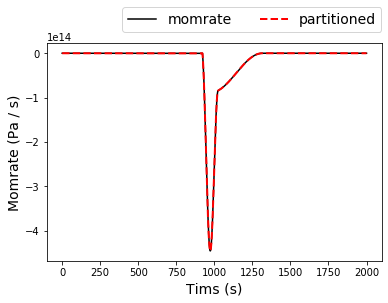

In [26]:
## plot some momrate time histories on partitioned subfaults
## detect_subfault.py and plot_subfault.py

split_dir = f'{os.getcwd()}/srcpart/split_faults/'
flist = glob.glob(f'{split_dir}/fault00*')

# 400 is multiple of nt_mom // read_step, used in srcpart.lsf
print(f"Number of nodes with some sources: {len(flist) // 400}")  
select = np.random.randint(len(flist), size=20)
for x in select:
    split_name = flist[x]
    data = np.fromfile(split_name, dtype='float32')
    if max(np.abs(data)) < 1e-12:
        print(f"{split_name.split('/')[-1]}:  Likely all zeros")
    else:
        idx = np.argmax(np.abs(data))
        break
        
print('\n', split_name.split('/')[-1])
  
              
# (366, 001) is suspicious
#split_name = split_dir + "fault0000366_001"
              
              
split = split_name.split('/')[-1]
rank = int(split.split('_')[-1]) - 1
tpsrc = split.replace("fault", "tpsrc").split('_')[0]
all_tpsrc = np.fromfile(f'{os.getcwd()}/srcpart/tpsrc/{tpsrc}', dtype='int32').reshape(-1, 3)
npsrc = all_tpsrc[0, 0]
all_tpsrc = all_tpsrc[1:, :]
print("Number of subfaults: ", npsrc)
assert len(all_tpsrc) == npsrc, "Number of subfaults not consistent!"

# shape of partitioned sources = (6, read_step, npsrc)
data = np.fromfile(split_name, dtype='f').reshape(6, read_step, npsrc)
idx = np.argmax(np.abs(data))
i_comp, _, i_src = np.unravel_index(idx, (6, read_step, npsrc))
print(f"Max momrate = {np.max(data)}, at {i_src} / {npsrc}")
idx_tpsrc = all_tpsrc[i_src, :]
idx_tpsrc = idx_tpsrc   # index of subfaults start from 1
print(f"Coordinates of the subfault: {idx_tpsrc}")

              
m0_mom = m0_part = 0
for i_comp in range(1):
    with open("momrate.dat", 'rb') as f_mom:
        f_mom.seek((12 + 4 * 6 * nt_mom) * (nx * (idx_tpsrc[2] - 1)), 0)
        ix, _, _ = np.frombuffer(f_mom.read(12), dtype='int32')
        f_mom.seek((12 + 4 * 6 * nt_mom) * (idx_tpsrc[0] - ix) - 12, 1)  #  to find the subfault fatser
        ix, _, _ = np.frombuffer(f_mom.read(12), dtype='int32')
        while ix != idx_tpsrc[0]:
            f_mom.seek(4 * 6 * nt_mom, 1)
            ix, iy, iz = np.frombuffer(f_mom.read(12), dtype='int32')
        print("Coordinates of the subfault in momrate.dat: ", ix , iy, iz)
        # momrate has 6 components
        buf_mom = np.frombuffer(f_mom.read(
                    4 * 6 * nt_mom), dtype='f')[i_comp::6]
    print("Momrate read!")
    buf_part = []  # momrate time histories at partitioned subfaults
    for i in range(1, nt_mom // read_step + 1):
        tmp = np.fromfile(split_name[:-3] + f'{i:03d}',
                          dtype='f').reshape(6, read_step, npsrc)
        buf_part = np.append(buf_part, tmp[i_comp, :, i_src])
    print("Partitioned momrate read! ")
    m0_mom += np.sum(buf_mom) * dt
    m0_part += np.sum(buf_part) * dt
    fig, ax = plt.subplots()
    ax.plot(np.arange(0, nt_mom * dt, dt), buf_mom,
            'k', linewidth=1.5, label='momrate')
    ax.plot(np.arange(0, nt_mom * dt, dt), buf_part,
            'r--', linewidth=2, label='partitioned')
    # ax.plot(np.arange(0, nt_mom * dt, ntskp * dt), slipr[:, idx_tpsrc[2], idx_tpsrc[0]], 'g', linewidth=2)
    ax.set_xlabel('Tims (s)')
    ax.set_ylabel('Momrate (Pa / s)')
    ax.legend(bbox_to_anchor=(1.02, 1.2), ncol=2,
              fancybox=True, loc="upper right")
    fig.savefig(f"plot_max_subfaults.png", dpi=600, bbox_inches='tight', pad_inches=0.05)
              


## TODO
The partitioned source is not consistent with the original momrate.dat for now.

[3439 2095    3]
18787 / 1125520 among total sources.
3432
3433 2095 3
3435 2095 3
3435 2095 3
3436 2095 3
3438 2095 3
3439 2095 3
3439


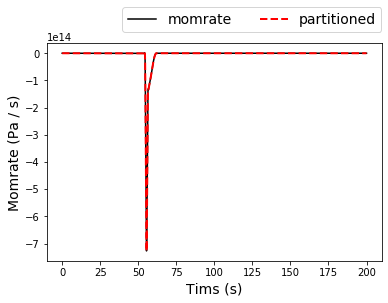

In [34]:
# Combine stf from partitioned sources on a subfault; verify if consistent with momrate.dat

i_comp, i_src = 1, 200
idx_tpsrc = all_tpsrc[i_src, :] # index of subfaults start from 1
print(idx_tpsrc)
disp = idx_tpsrc[0] + (idx_tpsrc[2]) * nx  

m0_mom = m0_part = 0
for i_comp in range(1):
    with open("momrate.dat", 'rb') as f_mom:
        f_mom.seek((12 + 4 * 6 * nt_mom) * (nx * (idx_tpsrc[2] - 1) + 2810), 0)
        ix, _, _ = np.frombuffer(f_mom.read(12), dtype='int32')
        print(ix)
        while ix != idx_tpsrc[0]:
            f_mom.seek(4 * 6 * nt_mom, 1)
            ix, iy, iz = np.frombuffer(f_mom.read(12), dtype='int32')
            print(ix, iy, iz)
        print(ix)
        # momrate has 6 components
        buf_mom = np.frombuffer(f_mom.read(
                    4 * 6 * nt_mom), dtype='f')[i_comp::6]
    print("Momrate read!")
    buf_part = []  # momrate time histories at partitioned subfaults
    for i in range(1, nt_mom // read_step + 1):
        tmp = np.fromfile(split_name[:-3] + f'{i:03d}',
                          dtype='f').reshape(6, read_step, npsrc)
        buf_part = np.append(buf_part, tmp[i_comp, :, i_src])
    print("Partitioned momrate read! ")
    m0_mom += np.sum(buf_mom) * dt
    m0_part += np.sum(buf_part) * dt
    fig, ax = plt.subplots()
    ax.plot(np.arange(0, nt_mom * dt, dt), buf_mom,
            'k', linewidth=1.5, label='momrate')
    ax.plot(np.arange(0, nt_mom * dt, dt), buf_part,
            'r--', linewidth=2, label='partitioned')
    # ax.plot(np.arange(0, nt_mom * dt, ntskp * dt), slipr[:, idx_tpsrc[2], idx_tpsrc[0]], 'g', linewidth=2)
    ax.set_xlabel('Tims (s)')
    ax.set_ylabel('Momrate (Pa / s)')
    ax.legend(bbox_to_anchor=(1.02, 1.2), ncol=2,
              fancybox=True, loc="upper right")

    #idx_rup = np.append(np.argwhere(np.abs(buf_mom) > 1e5), np.argwhere(np.abs(buf_part) > 1e5))
    #idx_rup = np.sort(np.unique(idx_rup))
    # if np.argmax(buf_mom) > nt_mom / 2:
    #    ax2 = ax.inset_axes([0.1, 0.1, 0.6, 0.4], zorder=5)
    # else:
    #    ax2 = ax.inset_axes([0.4, 0.1, 0.6, 0.4], zorder=5)
    #ax2.plot(idx_rup * dt, buf_mom[idx_rup], 'k')
    #ax2.plot(idx_rup * dt, buf_part[idx_rup], 'r--')

In [29]:
i_comp, i_src = 1, 200
idx_tpsrc = all_tpsrc[i_src, :]  # index of subfaults start from 1
#idx_tpsrc = [706, 2026, 1]
print(idx_tpsrc)
disp = idx_tpsrc[0] + idx_tpsrc[2] * nx
print(disp)
with open("momrate.dat", 'rb') as f_mom:    
    f_mom.seek((12 + 4 * 6 * nt_mom) * nx * (idx_tpsrc[2] - 1) , 0)
    ix, iy, iz = np.frombuffer(f_mom.read(12), dtype='int32')
    f_mom.seek((12 + 4 * 6 * nt_mom) * (idx_tpsrc[0] - ix) - 12, 1)  
    ix, iy, iz = np.frombuffer(f_mom.read(12), dtype='int32')
#     while ix != idx_tpsrc[0]:
#         f_mom.seek(12 + 4 * 6 * nt_mom, 1)
#         ix, iy, iz = np.frombuffer(f_mom.read(12), dtype='int32')
print(ix, iy, iz)

[3439 2095    3]
18787
3355 2083 3


i= 1
i= 2
i= 3
i= 4
i= 5
i= 6
i= 7
i= 8
i= 9
i= 10
i= 11
i= 12
i= 13
i= 14
i= 15
i= 16
i= 17
i= 18
i= 19
i= 20
i= 21
i= 22
i= 23
i= 24
i= 25
i= 26
i= 27
i= 28
i= 29
i= 30
i= 31
i= 32
i= 33
i= 34
i= 35
i= 36
i= 37
i= 38
i= 39


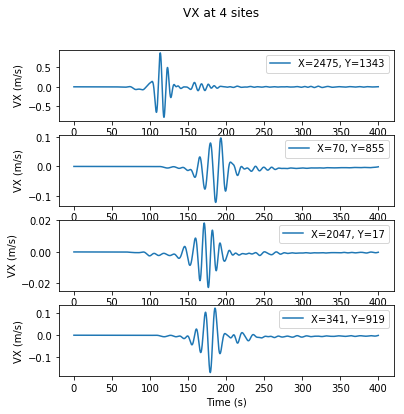

In [14]:
## plot 4 randomly selected ssmgrms

N = 4
# np.random.seed()
ix = np.random.randint(NX, size=N)
iy = np.random.randint(NY, size=N)
vx = np.zeros((N, nt // ntskp))
for i in range(1, nt // skip):
    print("i=", i)
    idx = np.arange((i - 1) * wstep, i * wstep)
    v = np.fromfile('output_sfc_back/SX_0_'+ f'{i * skip:07d}', dtype='f').reshape(-1, NY, NX)
    for j in range(N):
        vx[j, idx] = v[:, iy[j], ix[j]]

vx = filt_B(vx, 1 / dt, 0, 1)
fig, ax = plt.subplots(N, 1, figsize=(6, 6))
fig.suptitle(f'VX at {N} sites')
for j in range(N):
    ax[j].plot(t, vx[j, :], label=f'X={ix[j]}, Y={iy[j]}')
    ax[j].set_ylabel('VX (m/s)')
    ax[j].legend(loc=1)
ax[N - 1].set_xlabel('Time (s)')
fig.savefig('ssmgrm_rand_sites.png', dpi=300, bbox='tight', pad_inches=0.1)

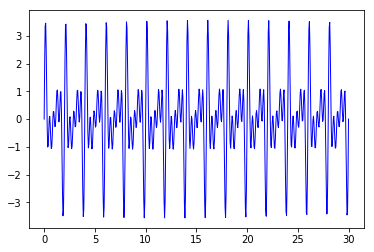

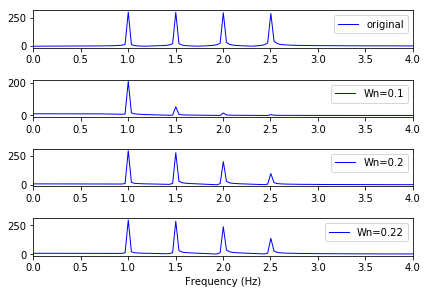

In [9]:
## check if the parameters are correct in comp_source_filter.py
## Wn = 0.2 --- filter up to 2Hz

from scipy.fftpack import fft
from scipy.signal import butter, lfilter

N = 600           # Number of samplepoints
Fs = 20.0
T = 1.0 / Fs      # N_samps*T (#samples x sample period) is the sample spacing.
x = np.linspace(0, N*T, N)     # the interval
y = 1*np.sin(1 * 2.0*np.pi*x) + 1*np.sin(1.5 * 2.0*np.pi*x) + 1*np.sin(2 * 2.0*np.pi*x)  + 1*np.sin(2.5 * 2.0*np.pi*x) # the signal
xf = np.linspace(0, Fs, len(y))

fig, ax = plt.subplots()
ax.plot(x, y, lw=1.0, c='b')

mean_removed = np.ones_like(y)*np.mean(y)
y = y - mean_removed

y0 = abs(fft(y))

b, a = butter(4, 0.1, 'low')
z = lfilter(b, a, y)
y1 = abs(fft(z))

b, a = butter(4, 0.2, 'low')
z = lfilter(b, a, y)
y2 = abs(fft(z))

b, a = butter(4, 0.22, 'low')
z = lfilter(b, a, y)
y3 = abs(fft(z))


fig, ax = plt.subplots(4, 1)
plt.tight_layout()
ax[0].plot(xf, y0, lw=1.0, c='b', label='original')
ax[0].set_xlim([0, 4])
ax[0].legend()
ax[1].plot(xf, y1, lw=1.0, c='b', label='Wn=0.1')
ax[1].set_xlim([0, 4])
ax[1].legend()
ax[2].plot(xf, y2, lw=1.0, c='b', label="Wn=0.2")
ax[2].set_xlim([0, 4])
ax[2].legend()
ax[3].plot(xf, y3, lw=1.0, c='b', label="Wn=0.22")
ax[3].set_xlabel('Frequency (Hz)')
plt.xlim([0, 4])
plt.legend()